# Audio Phase Encoding
This code hides and retrieves secret messages in an audio file using phase encoding.
The message bits are converted to phase shifts in the frequency domain:
+π/2 for bit 1 and –π/2 for bit 0.
During decoding, the audio’s phases are checked — positive means 1, negative means 0 — to reconstruct the original text.

In [1]:
# install/imports
import os
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt

In [2]:
# Creating Sample Audio wave

rate = 44100  # Sampling rate
duration = 2  # seconds
freq = 440    # Hz
t = np.linspace(0, duration, int(rate*duration), endpoint=False)
signal = 0.5 * np.sin(2 * np.pi * freq * t)

wavfile.write("input.wav", rate, (signal * 32767).astype(np.int16))


## Step 1 — Encode (segmentation + FFT)
 `encode()` function:

1. **Read the Audio File**  
   - The input audio file is read using `wavfile.read(audioLocation)`.  
   - The sampling rate (`rate`) and raw audio data (`audioData`) are extracted.  
   - If stereo audio is detected, only one channel is used for embedding.

2. **Prepare the Secret Message**  
   - The message is converted into binary form (8 bits per character, ASCII).
   - A 32-bit header is added at the beginning, representing the total message length (in bits).
   - The final binary stream (full_msgbin) contains both the header and the message bits.

3. **Select the Encoding Segment**  
   - A fixed-length segment of 8192 samples (seglen) from the start of the audio is used for encoding.
   - This segment is sufficient to hide short messages without perceptible distortion.

4. **Apply Fourier Transform (FFT)**
   - The segment is transformed into the frequency domain using FFT.
   - The result provides amplitude and phase information for each frequency bin.

5. **Embed the Binary Message into Phase Data**
   - Starting from index 1 (to skip the DC component), each message bit modifies one phase value:
      - Bit 1 → +π/2 (positive phase)
      - Bit 0 → –π/2 (negative phase)
   - Only the phase values are changed; amplitudes remain unchanged to preserve sound quality.

6. **Reconstruct the Modified Audio**
   - The modified frequency data is converted back to the time domain using inverse FFT (ifft).
   - The new segment replaces the original first 8192 samples in the audio data.

7. **Save the Encoded Audio File**
   - The resulting signal is saved as a new .wav file named "encoded_<originalname>.wav".
   - The output audio now contains the hidden text message embedded in its phase component.

In [3]:
# ENCODE FUNCTION
def encode_message(audio_file, message):
    """
    Encodes a message into the phase of an audio file.

    Args:
        audio_file (str): Path to the input WAV file.
        message (str): The message to be encoded.
    Returns:
        str: Path to the output WAV file with the encoded message.
    """
    try:
        rate, channels = wavfile.read(audio_file)
    except FileNotFoundError:
        print(f"Error: The file '{audio_file}' was not found.")
        return

    ch = channels[:, 0] if channels.ndim > 1 else channels
    
    msglen_bits = np.array([int(b) for b in format(8 * len(message), '032b')], dtype=np.uint8)
    msgbin = np.array([int(y) for x in message for y in format(ord(x), '08b')], dtype=np.uint8)
    
    full_msgbin = np.concatenate([msglen_bits, msgbin])
    total_bits = len(full_msgbin)
    
    seglen = 8192 
    
    if seglen // 2 + total_bits > seglen:
        print("Error: Message is too long for the chosen segment size.")
        return
        
    if seglen > len(ch):
        print("Error: Audio file is too short.")
        return
        
    x = ch[:seglen]
    fft_result = np.fft.fft(x)
    phases = np.angle(fft_result)
    amplitudes = np.abs(fft_result)
    
    start_idx = 1
    
    phases[start_idx : start_idx + total_bits] = np.where(full_msgbin == 1, np.pi/2, -np.pi/2)
    
    new_fft_result = amplitudes * np.exp(1j * phases)
    new_ch = np.fft.ifft(new_fft_result).real
    encoded_ch = np.concatenate([new_ch, ch[seglen:]])
    encoded_ch = encoded_ch.astype(channels.dtype)
    output_file = "encoded_" + audio_file
    wavfile.write(output_file, rate, encoded_ch)
    
    print(f"Message encoded successfully and saved to '{output_file}'")
    print(f"FFT Segment length used for encoding: {seglen} samples.")

    return output_file

## Step 2 — Decode
`decode()` function:

1. **Read the Encoded Audio File**
   - The encoded .wav file is read using scipy.io.wavfile.read().
   - The sampling rate (rate) and the audio data (channels) are extracted.
   - If the audio is stereo, only the first channel is used for decoding.

2. **Define Decoding Parameters**
   - The decoding uses the same fixed segment length (seglen = 8192) as the encoder.
   - Decoding starts from index 1 to skip the DC frequency component.

3. **Extract Phase Information**
   - The first 8192 samples of the audio are transformed using FFT.
   - The phase angles of the transformed data are extracted using np.angle().

4. **Retrieve the Message Length (Header)**
   - The first 32 phase values (after index 1) represent the message length in bits.
      - If a phase is positive, it is interpreted as bit 1.
      - If negative, it is interpreted as bit 0.
   - These 32 bits are converted into an integer, giving the message length.

5. **Extract the Encoded Message Bits**
   - Using the decoded length, the following phase values are interpreted as message bits.
   - Again, positive phase → 1, negative phase → 0.

6. **Reconstruct the Original Message**
   - The bitstream is reshaped into 8-bit groups (one byte per character).
   - Each byte is converted into its ASCII equivalent to recover the original characters.
   - The full decoded message string is returned.

In [4]:
import numpy as np
import scipy.io.wavfile

def decode_message(encoded_audio_file):
    """
    Decodes a message from the phase of an audio file.

    Args:
        encoded_audio_file (str): Path to the encoded WAV file.

    Returns:
        str: The decoded message or an error message.
    """
    try:
        rate, channels = scipy.io.wavfile.read(encoded_audio_file)
    except FileNotFoundError:
        return "Error: The encoded audio file was not found."

    ch = channels[:, 0] if channels.ndim > 1 else channels
    
    seglen = 8192 
    start_idx = 1
    
    if len(ch) < seglen:
        return "Error: Audio file is too short for the chosen segment length."

    phases = np.angle(np.fft.fft(ch[:seglen]))

    # Read the 32 bits of message length. This condition is now correct.
    msglen_bits = (phases[start_idx : start_idx + 32] >= 0).astype(np.int8)

    if msglen_bits.size < 32:
        return "Error: Could not decode 32 message length bits."

    msglen_val = msglen_bits.dot(1 << np.arange(31, -1, -1))
    print('Decoded message length (bits):', msglen_val)

    # Now, read the message bits using the decoded length
    msg_start_idx = start_idx + 32
    msg_end_idx = msg_start_idx + msglen_val
    
    if msg_end_idx > len(phases):
        return "Error: Decoded message length is too large for the audio segment. Possible corruption."

    # This condition is also corrected to match the encoding
    msgbin = (phases[msg_start_idx : msg_end_idx] >= 0).astype(np.int8)

    if len(msgbin) % 8 != 0:
        return "Error: Decoded message bits are not a multiple of 8. Corruption in message."
    else:
        msg_bytes = msgbin.reshape((-1, 8)).dot(1 << np.arange(7, -1, -1))
        decoded_msg = ''.join(np.char.mod('%c', msg_bytes))
        return decoded_msg

# Step 3 — Demonstration and Execution


In [5]:
# =============================
# DEMO: Audio Steganography
# =============================

# Path to your input WAV file
"""
Some sample messages to test for particular audio files:
audio1 = steganography
audio2 = help
audio3 = hi steganography
audio4 = secret message
audio5 = sos help
"""

input_audio_path = "audio4.wav"   # <-- replace with your actual WAV file path

# Secret message to hide
secret_message = input("Enter Message :")
secret_message = secret_message.strip().lower()

# Step 1: Encode the message into the audio
print("Encoding message into audio...")
encoded_audio_path = encode_message(input_audio_path, secret_message)
print(f"Encoded audio saved at: {encoded_audio_path}")

# Step 2: Decode the message from the encoded audio
print("\nDecoding message from audio...")
print(encoded_audio_path)
decoded_message = decode_message(encoded_audio_path)
decoded_message = decoded_message.lower()
print(f"Decoded message: '{decoded_message}'")

Encoding message into audio...
Message encoded successfully and saved to 'encoded_audio4.wav'
FFT Segment length used for encoding: 8192 samples.
Encoded audio saved at: encoded_audio4.wav

Decoding message from audio...
encoded_audio4.wav
Decoded message length (bits): 112
Decoded message: 'secret message'


## Step 3.1 — Visualize Audio Phase

The `visualize_audio_phase()` function compares the **phase spectra** of the original input audio and the encoded output audio to analyze changes caused by the steganography process.

### How It Works
1. **Read Audio Files**  
   - Uses `scipy.io.wavfile.read()` to load the WAV files.  
   - If the audio is stereo, only the **first channel** is used for analysis.

2. **FFT for Phase Analysis**  
   - Computes the **Fast Fourier Transform (FFT)** of both signals.  
   - Extracts the **phase angles** from the FFT using `np.angle()`.

3. **Plot Phase Spectra**  
   - Creates two subplots:
     - **Top:** Phase spectrum of the original input audio.
     - **Bottom:** Phase spectrum of the output (encoded) audio.
   - Each plot shows **frequency bins** on the X-axis and **phase in radians** on the Y-axis.

### Purpose
By visualizing the phase spectra before and after encoding, we can:
- Detect **phase shifts** introduced by message embedding.
- Evaluate if the steganography method significantly alters the audio's phase characteristics, which might be detectable by steganalysis.


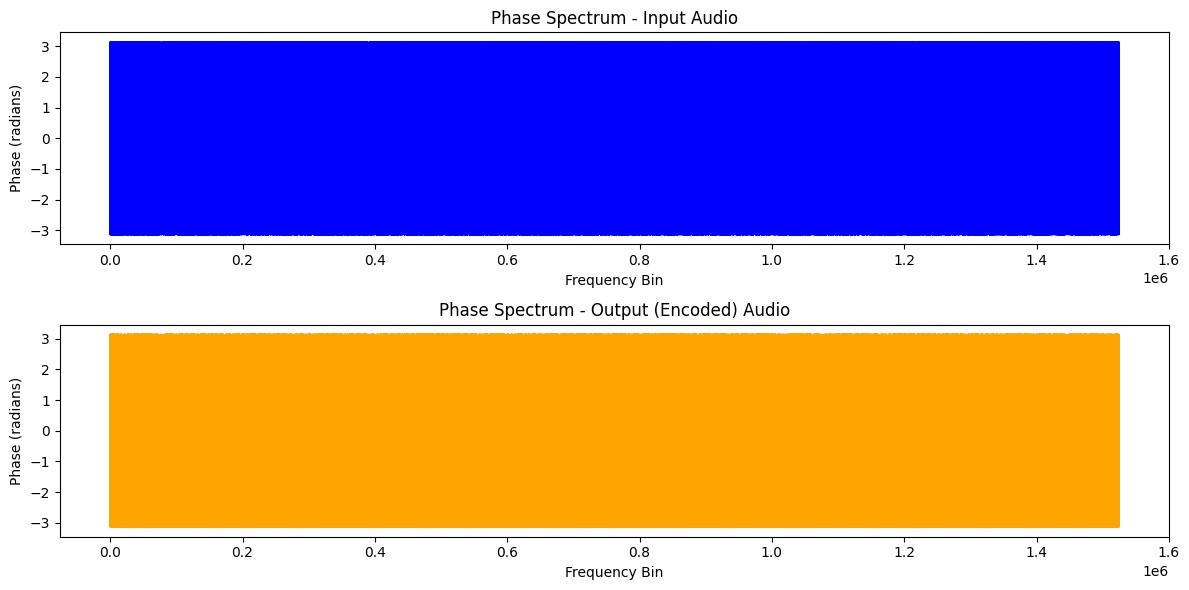

In [6]:
# Step 3.1: Visualization
def visualize_audio_phase(input_path, output_path):
    # Read input audio
    rate_in, data_in = wavfile.read(input_path)
    if data_in.ndim > 1:
        data_in = data_in[:, 0]  # Take only first channel

    # Read output audio
    rate_out, data_out = wavfile.read(output_path)
    if data_out.ndim > 1:
        data_out = data_out[:, 0]

    # FFT for phase analysis
    phase_in = np.angle(np.fft.fft(data_in))
    phase_out = np.angle(np.fft.fft(data_out))

    # Plot
    plt.figure(figsize=(12, 6))

    plt.subplot(2, 1, 1)
    plt.plot(phase_in, color='blue')
    plt.title("Phase Spectrum - Input Audio")
    plt.xlabel("Frequency Bin")
    plt.ylabel("Phase (radians)")

    plt.subplot(2, 1, 2)
    plt.plot(phase_out, color='orange')
    plt.title("Phase Spectrum - Output (Encoded) Audio")
    plt.xlabel("Frequency Bin")
    plt.ylabel("Phase (radians)")

    plt.tight_layout()
    plt.show()

visualize_audio_phase("audio3.wav", "encoded_audio3.wav")

### Step 3.2 — Verification

In this step, we verify that the decoded message exactly matches the original secret message we embedded into the audio.  
If the extraction process is correct and no data corruption has occurred, both strings will be identical.  

**Expected Output:**
-  **Success!** if the decoded message matches the original.
-  **Warning!** if there’s any mismatch, indicating potential errors in encoding/decoding or audio alteration.


In [7]:
# Step 3.2: Verification
if decoded_message == secret_message:
    print("\n Success! The decoded message matches the original.")
else:
    print("\n Warning! The decoded message does NOT match the original.")


 Success! The decoded message matches the original.


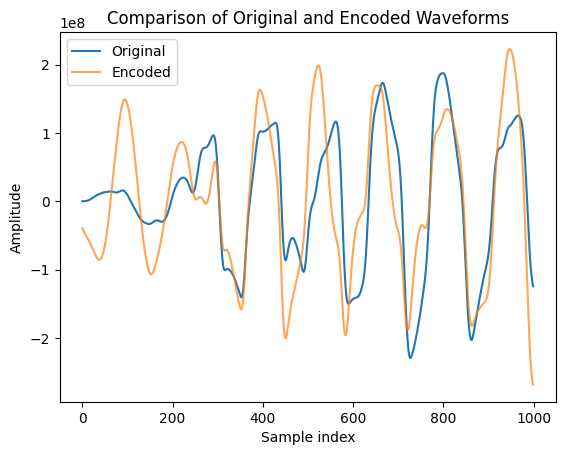

In [8]:
import matplotlib.pyplot as plt
rate, orig = wavfile.read("audio4.wav")
rate, encd = wavfile.read("encoded_audio4.wav")

# If stereo, use only the first channel for both
if orig.ndim > 1:
    orig = orig[:, 0]
if encd.ndim > 1:
    encd = encd[:, 0]

plt.figure()
plt.plot(orig[:1000], label="Original")
plt.plot(encd[:1000], label="Encoded", alpha=0.7)
plt.legend()
plt.title("Comparison of Original and Encoded Waveforms")
plt.xlabel("Sample index")
plt.ylabel("Amplitude")
plt.show()